In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt

sys.path.insert(0, './TetrisEnv')
from TetrisBattle.envs.tetris_env import TetrisSingleEnv, TetrisEnv
from TetrisBattle import *
from Model.Feature_Extraction import TetrisActorCriticCnnPolicy
# %pip install -e ./TetrisEnv
# import TetrisBattle
%load_ext autoreload
%autoreload 2
# from gym import make
# env = make('SinglePTetris-v0')

pygame 2.5.2 (SDL 2.28.3, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
from gym.wrappers import GrayScaleObservation
from preprocessing.EensyWeensy import MakeEensyWeensy
from preprocessing.NewReduceActions import ReduceActions
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv

env = TetrisSingleEnv(obs_type='grid')
# env = GrayScaleObservation(env, keep_dim=True)
# env = MakeEensyWeensy(env, cut_in_half=True, scale=.25)
env = ReduceActions(env)
env = DummyVecEnv([lambda: env])
# env = VecFrameStack(env, 4, channels_order="last")
# ob = env.reset()
# plt.imshow(ob, cmap="plasma")

in reset S
in reset S


in reset J
in reset J
in reset S
in act L


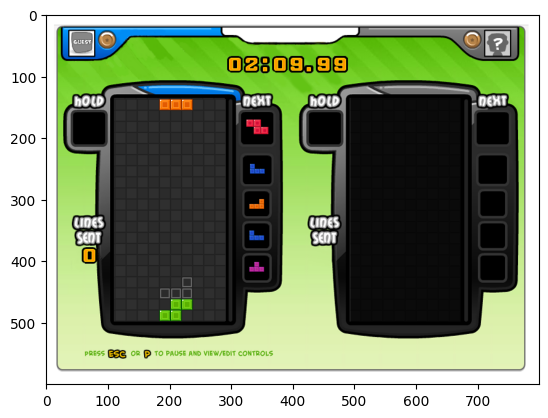

In [3]:
env = TetrisSingleEnv()
ob = env.reset()

state, reward, done, info = env.step(str(2))
plt.imshow(state, cmap = 'plasma')


In [9]:
# env = TetrisSingleEnv()
# env = ReduceActions(env)
# env.reset()
# for i in range(1000):
#     # action = int(input('>'))
#     action = env.action_space.sample()
#     # print('block level action', action)
#     state, reward, done, info = env.step(action)
#     # print('reward', reward)
#     if done:
#         env.reset()
#     env.render()

# env.close()

In [10]:
import os 
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_checker import check_env
import torch
print(torch.cuda.is_available())
# check_env(env)

True


In [11]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True
    
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [12]:
try:
    del model
except NameError:
    pass
model = PPO(TetrisActorCriticCnnPolicy, env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=1e-4, n_steps=64, device="cuda") 
# model = PPO.load('./train/cams100000')
# model.set_env(env)

Using cuda device


In [13]:
model.learn(total_timesteps=1000000, callback=callback)

Logging to ./logs/PPO_26
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.7     |
|    ep_rew_mean     | -40.3    |
| time/              |          |
|    fps             | 11       |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 64       |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 18.1         |
|    ep_rew_mean          | -41.3        |
| time/                   |              |
|    fps                  | 12           |
|    iterations           | 2            |
|    time_elapsed         | 10           |
|    total_timesteps      | 128          |
| train/                  |              |
|    approx_kl            | 8.369889e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.53        |
|    explained_variance   | 0.004

In [8]:
model = PPO.load('./train/best_model_120000')
env = TetrisSingleEnv(obs_type='grid')
# env = GrayScaleObservation(env, keep_dim=True)
# env = MakeEensyWeensy(env, cut_in_half=True, scale=.25)
env = ReduceActions(env)
env = DummyVecEnv([lambda: env])
# env = VecFrameStack(env, 4, channels_order="last")
state = env.reset()

for i in range(0, 10000):
    action, _ = model.predict(state)
    # action = env.action_space.sample()
    # print(action)
    state, reward, done, info = env.step(action)
    env.render()

env.close()

wow i cleared a line!
wow i cleared a line!
wow i cleared a line!
wow i cleared a line!
wow i cleared a line!
wow i cleared a line!
wow i cleared a line!


In [ ]:
# class InputGetter():
#     def __init__(self):
#         self.input_log = []
        
#     def get_input(self):
#         while True:
#             try:
#                 if len(self.input_log) == 0:
#                     self.input_log = [*input(">")]
                
#                 inp = self.input_log.pop(0)
#                 inp = int(inp)
#                 assert(inp in [0, 1, 2, 3, 4, 5, 6, 7, 9])
#                 return inp
#             except Exception as e:
#                 print(e)
# env = TetrisSingleEnv(obs_type="grid")
# i = 0
# inputter = InputGetter()
# while True:
#     action = inputter.get_input()
#     if action == 9:
#         env.close()
#         break
#     state, reward, done, info = env.step(action)
#     # print("infow", info)
#     # print("rewrd",reward)
#     env.render()
#     # print(env.game_interface.get_obs().shape)
#     grid = env.game_interface.get_obs()